In [21]:
import sys
sys.path.append("../gaia_tools/")
sys.path.append("../scripts/")
import data_analysis
import covariance_generation as cov
from import_functions import *
import photometric_cut
from mcmc_plots import *
import numpy as np
import emcee
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
from pylab import *
from scipy.optimize import curve_fit
from cProfile import label
import pandas as pd

In [22]:
headers = ['R', 'v_c', 'sig_below', 'sig_above']
eilers_rc = pd.read_csv("/home/svenpoder/repos/gaia-tools/jupyter-notebook/Eilers_RC_Data.csv", sep=' ', names=headers)
eilers_rc.columns

FileNotFoundError: [Errno 2] No such file or directory: '/home/svenpoder/repos/gaia-tools/jupyter-notebook/Eilers_RC_Data.csv'

In [66]:
# Rotation Curve Plotting Function

def plot_rotation_curve(is_fit_curve, mcmc_runs, labels, burnin, display_eilers=False, display_bin_edges=False):

    def func(x, a, b, c, ):
        return a*x*x + b*x + c

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['black', 'orange', 'blue', 'green']

    if(display_bin_edges):
        y_min = 0
        y_max = -300
    
    for i_path, path in enumerate(mcmc_runs):

        with open(path + '/run_settings.txt', 'rb') as handle:
            bin_setup = pickle.loads(handle.read())
            bin_centers_r = bin_setup['bin_centers_r']

        path = path + '/sampler_' + path.split('/')[-1].split('_')[0] + '.h5'
        reader = emcee.backends.HDFBackend(path, read_only=True)
        samples_data = reader.get_chain(discard=burnin[i_path])[:,:,0:10]
        flatchain = reader.get_chain(flat=True, discard = burnin[i_path])[:,0:10]

        bin_velocities = []
        ndim = samples_data.shape[2]
        
        for i in range(ndim):
            mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
            bin_velocities.append((v_mean, v_sub, v_sup))
        velocity_array = np.array(bin_velocities)

        if(len(mcmc_runs) == 0):
            x_offset = 0
            x_values = bin_centers_r + x_offset
        else:
            x_offset = [-200, -100, 0, 100]
            x_values = bin_centers_r + x_offset[i_path]
        y_values = velocity_array[:,0]

        y_error = [velocity_array[:,1], velocity_array[:,2]]
        plt.errorbar(x_values, -y_values,
                    yerr= y_error,
                    fmt='o', c=colors[i_path], label=labels[i_path])

        if(is_fit_curve):
            popt, pcov = curve_fit(func, bin_centers_r, -y_values, sigma=velocity_array[:,1])
            perr = np.sqrt(np.diag(pcov))
            fit = func(np.array(bin_centers_r), popt[0], popt[1], popt[2])
            plot(bin_centers_r, fit, colors[i_path], lw=2, linestyle="-", alpha=0.75, label='Fitted curve')

        if(display_bin_edges):
            if np.min(y_values) < y_min: y_min = np.min(y_values)
            if np.max(y_values) > y_max: y_max = np.max(y_values)

    plt.xlabel(r'$r$ [kpc]', fontdict={'fontsize' : 16})
    plt.ylabel(r'$v_c$ [km/s]',  fontdict={'fontsize' : 16})

    def numfmt(x, pos):
            s = '{}'.format(x / 1000.0)
            return s
    fmt = ticker.FuncFormatter(numfmt)
    ax.xaxis.set_major_formatter(fmt)

    bin_edges_r = bin_setup['bin_edges'][0][0]
    bin_edges_z = bin_setup['bin_edges'][1].T[0]

    if(display_bin_edges):
        ax.vlines(bin_edges_r, -y_min + 1, -y_max - 1, linestyles='dashed', alpha=0.5, colors='grey')
        ax.set_xticks(np.round(bin_edges_r))

    print(y_min)
    print(y_max)

    if(display_eilers):
        reduced_eilers = eilers_rc[eilers_rc.R <= 12]
        eilers_rc_y_values = np.array(reduced_eilers.v_c)
        eilers_rc_x_values = np.array(reduced_eilers.R*1e3)
        eilers_y_error = [np.array(reduced_eilers.sig_below), np.array(reduced_eilers.sig_above)]
        plt.errorbar(eilers_rc_x_values, eilers_rc_y_values, 
                    yerr=eilers_y_error, 
                    fmt='o', 
                    color='red',
                    label='Eilers et al. (2018)')
    plt.legend()
 
    r_range = r', $r \in [{},{}]$ kpc'.format(np.round(bin_edges_r[0]/1000), np.round(bin_edges_r[-1]/1000))
    z_range = r', $z \in [{},{}]$ pc'.format(np.round(bin_edges_z[0]), np.round(bin_edges_z[-1]))
    plt.title('Rotation Curve' + r_range + z_range, fontsize=18, pad=12)

    y_min = np.min(np.concatenate([eilers_rc_y_values, -y_values]))
    y_max = np.max(np.concatenate([eilers_rc_y_values, -y_values]))
    plt.xlim(5000, 12000)
    plt.ylim(y_min-3, y_max+3)
    #plt.show()

In [48]:
path1 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-11-15-11-20-19_range0.3'
path2 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-11-15-12-31-11_range0.3'
path3 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-11-15-13-10-06_range0.3'
path4 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-11-11-15-31-53_range0.3'


paths=[path1, path2, path3, path4]
labels =[]
samplers=[]

# Load run settings
folder_path = path1
with open(folder_path + '/run_settings.txt', 'rb') as handle:
    data = handle.read()
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

for folder_path in paths:
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')
    with open(folder_path + '/run_settings.txt', 'rb') as handle:
        bin_setup = pickle.loads(handle.read())
        for i, key in enumerate(bin_setup.keys()):
            print('{}. '.format(i+1) + key + '= {}'.format(bin_setup[key]))
        labels.append(r'$n = {}$'.format(bin_setup['nbins']))

1. bin_centers_r= [ 5367.81753383  6060.71100158  6753.60446932  7446.49793707
  8139.39140481  8832.28487256  9525.1783403  10218.07180804
 10910.96527579 11603.85874353]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 5021.37079996,  5714.26426771,  6407.15773545,  7100.0512032 ,
         7792.94467094,  8485.83813868,  9178.73160643,  9871.62507417,
        10564.51854192, 11257.41200966, 11950.30547741],
       [ 5021.37079996,  5714.26426771,  6407.15773545,  7100.0512032 ,
         7792.94467094,  8485.83813868,  9178.73160643,  9871.62507417,
        10564.51854192, 11257.41200966, 11950.30547741]]), array([[-200., -200., -200., -200., -200., -200., -200., -200., -200.,
        -200., -200.],
       [ 200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,
         200.,  200.]]))
4. nbins= 10
5. V_sun= [[ 11.1]
 [245.8]
 [  7.8]]
6. R_0= 8122
7. Z_0= 25
8. cut_range= 0.3
9. final_sample_size= (270281, 14)
10. disk_scale= 3000.0
11. vlos_dispersio

Sampler shape: (14000, 50, 12)


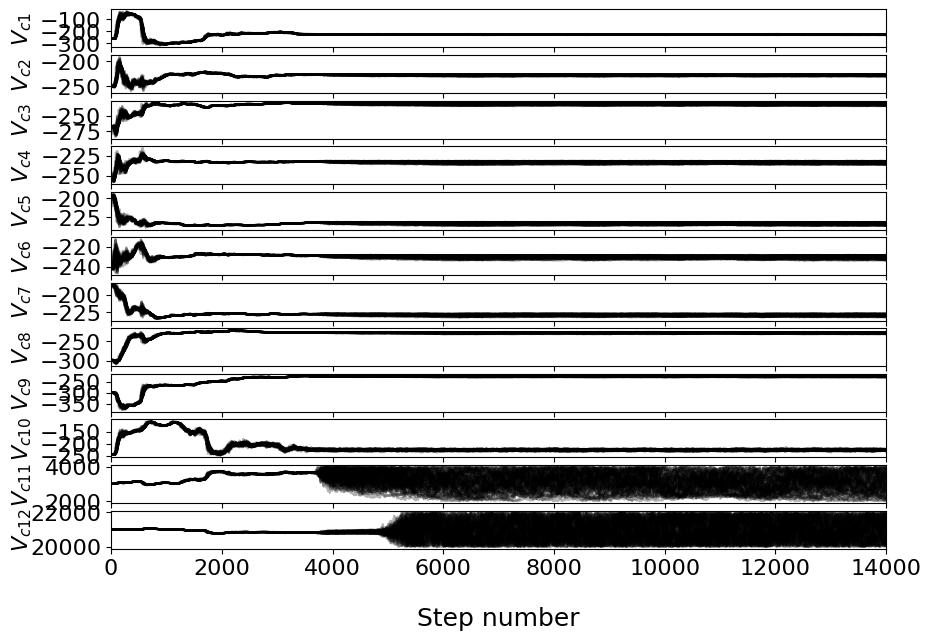

In [68]:
plot_walkers(samplers[2], 00)


In [53]:
paths

['/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-11-15-11-20-19_range0.3',
 '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-11-15-12-31-11_range0.3',
 '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-11-15-13-10-06_range0.3',
 '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-11-11-15-31-53_range0.3']

-233.45736163928572
-225.7497843734293


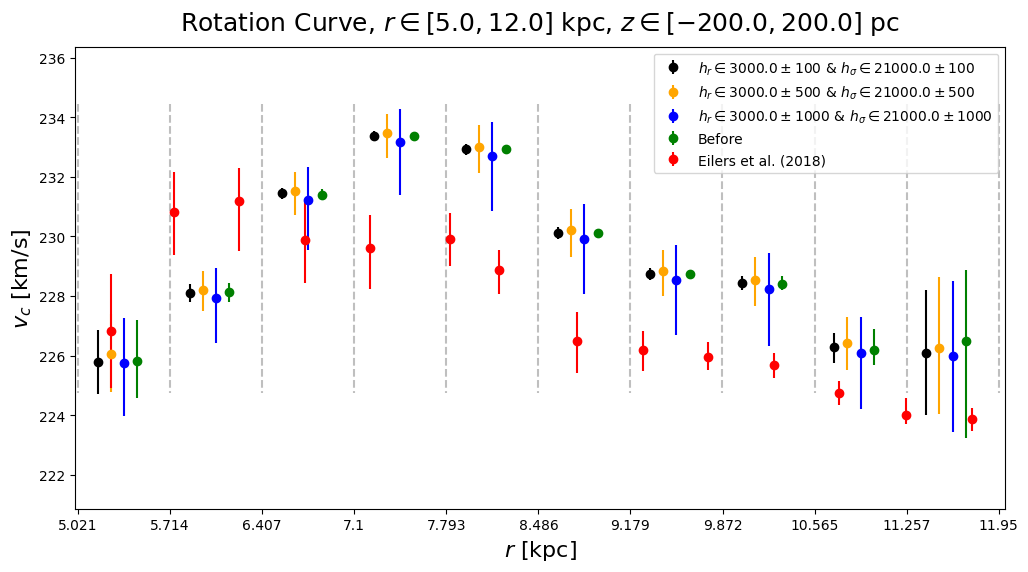

In [67]:
folder_path = path1
with open(folder_path + '/run_settings.txt', 'rb') as handle:
    data = handle.read()
bin_setup = pickle.loads(data)

h_r = bin_setup['disk_scale']
h_sig = bin_setup['vlos_dispersion_scale']

plot_rotation_curve(False, 
                    paths, 
                    [r'$h_r \in {} \pm 100$ & $h_\sigma \in {} \pm 100$'.format(h_r, h_sig), 
                    r'$h_r \in {} \pm 500$ & $h_\sigma \in {} \pm 500$'.format(h_r, h_sig),
                    r'$h_r \in {} \pm 1000$ & $h_\sigma \in {} \pm 1000$'.format(h_r, h_sig),
                    'Before'], 
                    [4000, 5500, 6000, 4000], display_eilers=True,
                    display_bin_edges=True)
#plt.ylim(223, 235)

# Asymmetric Drift Plots

In [23]:
path1 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-11-15-15-41-35_range0.3'

paths=[path1]
labels =[]
samplers=[]

# Load run settings
folder_path = path1
with open(folder_path + '/run_settings.txt', 'rb') as handle:
    data = handle.read()
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

for folder_path in paths:
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')
    with open(folder_path + '/run_settings.txt', 'rb') as handle:
        bin_setup = pickle.loads(handle.read())
        for i, key in enumerate(bin_setup.keys()):
            print('{}. '.format(i+1) + key + '= {}'.format(bin_setup[key]))
        labels.append(r'$n = {}$'.format(bin_setup['nbins']))

1. bin_centers_r= [ 5367.81753383  6060.71100158  6753.60446932  7446.49793707
  8139.39140481  8832.28487256  9525.1783403  10218.07180804
 10910.96527579 11603.85874353]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 5021.37079996,  5714.26426771,  6407.15773545,  7100.0512032 ,
         7792.94467094,  8485.83813868,  9178.73160643,  9871.62507417,
        10564.51854192, 11257.41200966, 11950.30547741],
       [ 5021.37079996,  5714.26426771,  6407.15773545,  7100.0512032 ,
         7792.94467094,  8485.83813868,  9178.73160643,  9871.62507417,
        10564.51854192, 11257.41200966, 11950.30547741]]), array([[-200., -200., -200., -200., -200., -200., -200., -200., -200.,
        -200., -200.],
       [ 200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,
         200.,  200.]]))
4. nbins= 10
5. V_sun= [[ 11.1]
 [245.8]
 [  7.8]]
6. R_0= 8122
7. Z_0= 25
8. cut_range= 0.3
9. final_sample_size= (270281, 14)
10. disk_scale= 3000.0
11. vlos_dispersio

Sampler shape: (5000, 50, 10)


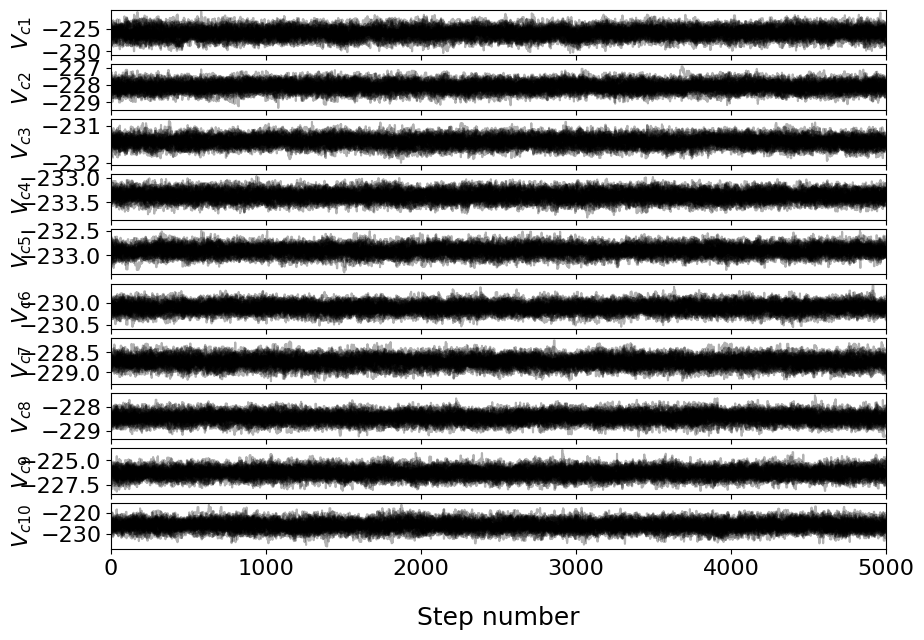

In [4]:
plot_walkers(samplers[0], 2000)

In [24]:
import pickle

In [25]:
path1 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-12-05-14-18-40_range0.3'

paths=[path1]
labels =[]
samplers=[]

# Load run settings
folder_path = path1
with open(folder_path + '/run_settings.txt', 'rb') as handle:
    data = handle.read()
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

for folder_path in paths:
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')
    with open(folder_path + '/run_settings.txt', 'rb') as handle:
        bin_setup = pickle.loads(handle.read())
        for i, key in enumerate(bin_setup.keys()):
            print('{}. '.format(i+1) + key + '= {}'.format(bin_setup[key]))
        labels.append(r'$n = {}$'.format(bin_setup['nbins']))

1. bin_centers_r= [ 5350.  6050.  6750.  7450.  8150.  8850.  9550. 10250. 10950. 11650.]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 5000.,  5700.,  6400.,  7100.,  7800.,  8500.,  9200.,  9900.,
        10600., 11300., 12000.],
       [ 5000.,  5700.,  6400.,  7100.,  7800.,  8500.,  9200.,  9900.,
        10600., 11300., 12000.]]), array([[-200., -200., -200., -200., -200., -200., -200., -200., -200.,
        -200., -200.],
       [ 200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,
         200.,  200.]]))
4. nbins= 10
5. V_sun= [[ 11.1]
 [245.8]
 [  7.8]]
6. R_0= 8122
7. Z_0= 25
8. cut_range= 0.3
9. final_sample_size= (270281, 14)
10. disk_scale= 3000.0
11. vlos_dispersion_scale= 21000.0
12. A_r_info= [(5350.0, 1675.5404176544107), (6050.0, 1588.0323138801214), (6750.0, 1728.8148348341194), (7450.0, 1816.3272077179356), (8150.0, 1879.6760640085947), (8850.0, 1888.921456646839), (9550.0, 1896.0958209907294), (10250.0, 1954.2968835596366), (1

In [26]:
# Gets V_c mean values and errors

burnin = 2000
path = samplers[0]
reader = emcee.backends.HDFBackend(path, read_only=True)
samples_data = reader.get_chain(discard=burnin)
flatchain = reader.get_chain(flat=True, discard = burnin)

bin_velocities = []
ndim = samples_data.shape[2]

for i in range(ndim):
    mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
    bin_velocities.append((v_mean, v_sub, v_sup))
velocity_array = np.array(bin_velocities)

Photometric cut..
Stars in the sample before making photometric cuts: (4807089, 22)
Stars in the sample after making photometric cuts: (2528249, 23)
Start import...
The dimensions of the data: (rows, columns) -> (7133471, 24)
Checking indexing... 

<bound method NDFrame.head of                    source_id          ra  ra_error        dec  dec_error  \
0        5933266834310007808  242.471074  0.330682 -52.806533   0.125811   
1        4103049637327213440  278.887615  0.117672 -15.350780   0.103104   
2        5951114420631264640  260.139995  0.042137 -46.794507   0.038528   
3        5966712023814100736  255.893150  0.069434 -41.563702   0.055033   
4        2198292118993038464  331.084711  0.039728  56.898851   0.041073   
...                      ...         ...       ...        ...        ...   
7133466  5959713078252724352  259.808524  0.251540 -41.875976   0.225424   
7133467  4057347680607821696  267.904540  0.079733 -28.918109   0.072635   
7133468  5827538590793373696  234.110

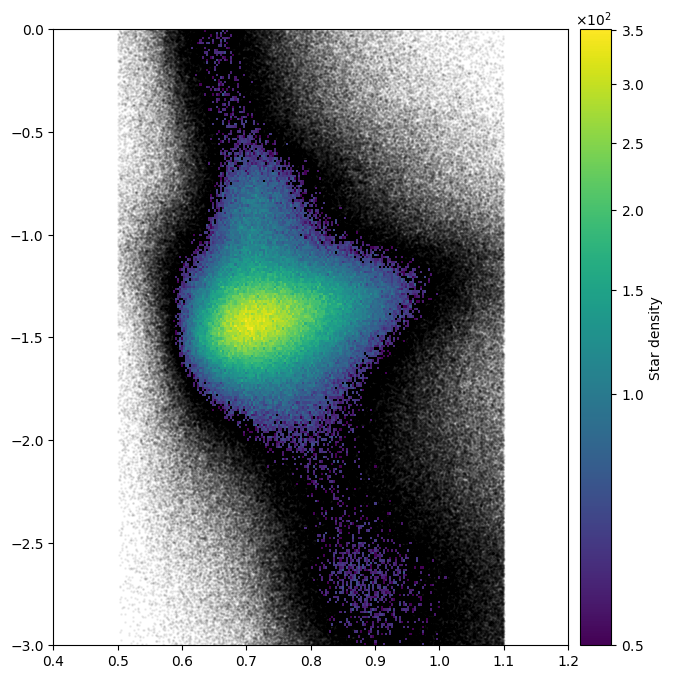

In [27]:
galcen_data, min_r, max_r = import_baseline_sample()

In [28]:
bin_collection = data_analysis.get_collapsed_bins(data = galcen_data,
                                                      theta = (0, 1),
                                                      BL_r_min = 5000,
                                                      BL_r_max = 12000,
                                                      BL_z_min = -200,
                                                      BL_z_max = 200,
                                                      N_bins = (10, 1),
                                                      r_drift = False,
                                                      debug = False)

In [36]:
# Gets weighted mean velocities and errors

bins = bin_collection.bins
weighted_mean_velocities = []
weighted_var_velocities = []

for i, bin in enumerate(bins):

    weights = 1/bins[i].data.sig_vphi
    weighted_avg, weighted_var = bins[i].weighted_avg_and_std(bins[i].data.v_phi, weights)

    mean = weighted_avg

    weighted_mean_velocities.append(mean)
    weighted_var_velocities.append(weighted_var)

weighted_mean_velocities = np.array(weighted_mean_velocities)
weighted_var_velocities = np.array(weighted_var_velocities)

In [67]:
# Compute va error
r, A = zip(*bin_setup['A_r_info'])
A = np.array(A)

va_error_array = []

for i,bin in enumerate(bin_collection.bins):
    v_c = velocity_array[:,0][0:-2][i]
    v_phi = weighted_mean_velocities[i]
    A_i = 2*A[i]

    # add the sub and sup and divide by 2
    vc_error = ((velocity_array[:,1][0:-2][i] + velocity_array[:,2][0:-2][i])/2)
    vphi_error = weighted_var_velocities[i]
    print("vc_error: {}".format(vc_error))
    print("vphi_error: {}".format(np.sqrt(vphi_error)))

    add_1 = -A_i*(v_c + v_phi)**(-2)*vc_error
    add_2 = -A_i*(v_c + v_phi)**(-2)*np.sqrt(vphi_error)

    va_error = np.sqrt(add_1**2 + add_2**2)
    print(va_error)

    va_error_array.append(va_error)

va_error_array = np.array(va_error_array)
va_error_array

vc_error: 1.657930842958251
vphi_error: 33.8429261985912
0.5709166748670255
vc_error: 1.1910734026401144
vphi_error: 30.267030540466898
0.47717089109698263
vc_error: 1.3090061817141105
vphi_error: 27.221002380948015
0.45464536627024776
vc_error: 1.3441433800106068
vphi_error: 26.046219095967768
0.44969594983068534
vc_error: 1.4096228522866738
vphi_error: 24.208221631735093
0.43529611909023425
vc_error: 1.4241192304607608
vphi_error: 23.123631102033816
0.42911744129623147
vc_error: 1.4225319640841008
vphi_error: 21.922837887198668
0.4135038860377689
vc_error: 1.470844905841659
vphi_error: 20.8484854840863
0.4064168773591294
vc_error: 1.4879071855972796
vphi_error: 19.906800213479624
0.3919216437883055
vc_error: 2.9321408308647676
vphi_error: 24.746159391749302
0.4247035051845106


array([0.57091667, 0.47717089, 0.45464537, 0.44969595, 0.43529612,
       0.42911744, 0.41350389, 0.40641688, 0.39192164, 0.42470351])

(array([6. , 6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

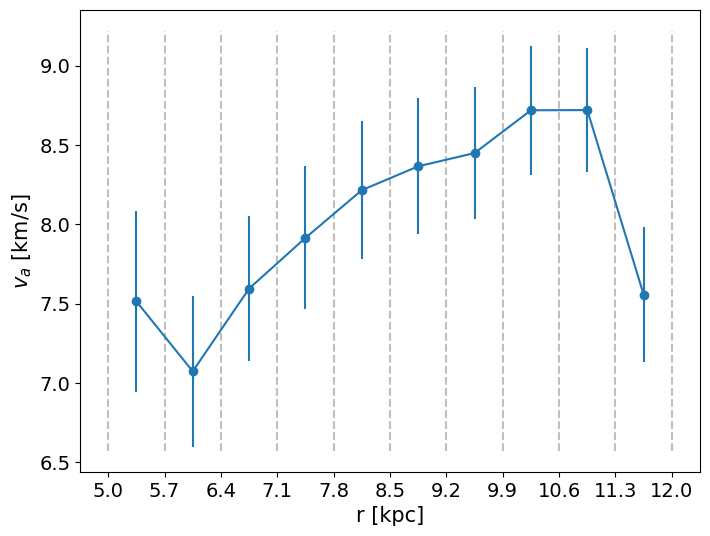

In [70]:
r, A = zip(*bin_setup['A_r_info'])

fig, ax = plt.subplots(figsize=(8, 6))

x = r
y = -2*np.array(A)/(velocity_array[:,0][0:-2] + weighted_mean_velocities)

ax.scatter(x, y)

plt.errorbar(x, y, 
                    yerr=va_error_array)

# plt.errorbar(x_values, -y_values,
#                     yerr= y_error,
#                     fmt='o', c=colors[i_path], label=labels[i_path])

def numfmt(x, pos):
            s = '{:.1f}'.format(x / 1000.0)
            return s
fmt = ticker.FuncFormatter(numfmt)
ax.xaxis.set_major_formatter(fmt)

bin_edges_r = bin_setup['bin_edges'][0][0]
bin_edges_z = bin_setup['bin_edges'][1].T[0]

ax.vlines(bin_edges_r, np.min(y) - 0.5, np.max(y) + 0.5, linestyles='dashed', alpha=0.5, colors='grey')
ax.set_xticks(bin_edges_r)

fontdict = {'fontsize' : 15}

ax.set_xlabel('r [kpc]', fontdict= fontdict)
ax.set_ylabel(r'$v_a$ [km/s]', fontdict= fontdict)

plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.title('Asymmetric Drift Velocity', fontsize=18, pad=12)